In [2]:
!pip install opencv-python

  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/66/82/564168a349148298aca281e342551404ef5521f33fba17b388ead0a84dc5/opencv_python-4.10.0.84-cp37-abi3-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 47.0 MB/s eta 0:00:0000:0100:01


In [35]:
import numpy as np
import cv2
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [36]:
# --- Step 1: Load Plant Image Dataset ---

def load_images_from_folder(folder_path, target_size=(128, 128)):
    """Load images from a folder, resize them, and convert to grayscale."""
    images = []
    labels = []
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):
            for file in os.listdir(label_path):
                file_path = os.path.join(label_path, file)
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):  # Ensure valid image formats
                    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        img = cv2.resize(img, target_size)
                        images.append(img)
                        labels.append(label)
                    else:
                        print(f"Warning: Unable to load image {file_path}")
    if len(images) == 0:
        raise ValueError("No valid images found in the dataset folder.")
    return np.array(images), np.array(labels)

In [37]:
# Load your dataset here
data_folder = "/Users/jayant/Documents/MA 544"
images, labels = load_images_from_folder(data_folder)

In [38]:
# Flatten the images for numerical processing
X = images.reshape(images.shape[0], -1)

# Encode labels as integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
# Compute PCA for dimensionality reduction
pca = PCA(n_components=50)  # Reduce to 50 principal components
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

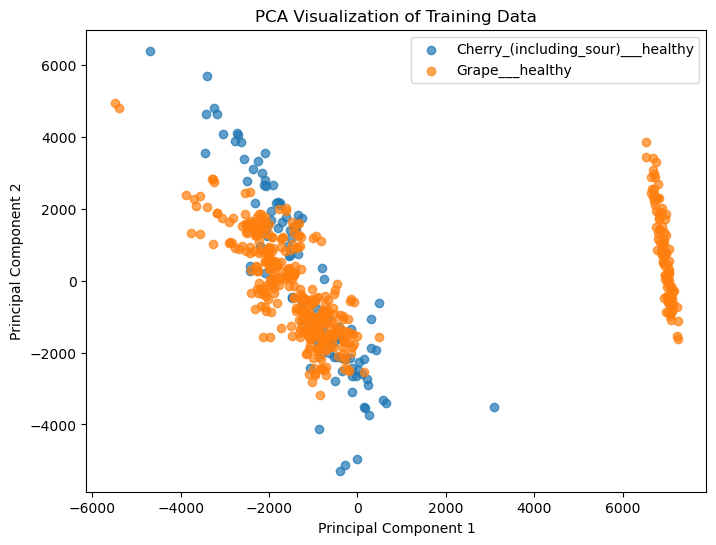

In [41]:
# PCA visualization
def plot_pca(X_pca, y, title="PCA Visualization"):
    """Visualize the PCA-reduced data."""
    plt.figure(figsize=(8, 6))
    for i, label in enumerate(np.unique(y)):
        plt.scatter(X_pca[y == label, 0], X_pca[y == label, 1], label=label_encoder.inverse_transform([label])[0], alpha=0.7)
    plt.title(title)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    plt.show()
    

plot_pca(X_train_pca, y_train, title="PCA Visualization of Training Data")

In [42]:
# Use Support Vector Machine (SVM) for classification
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train_pca, y_train)

SVC(kernel='linear', random_state=42)

In [43]:
# --- Step 5: Evaluate the Model ---
y_pred = svm_classifier.predict(X_test_pca)

In [44]:
# Generate a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# --- Step 6: Detect Disease in a New Image ---
def predict_disease(image_path):
    """Predict the disease for a given plant image."""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Unable to read the image at {image_path}. Check if the path is correct and the file is a valid image.")
    img = cv2.resize(img, (128, 128))
    img_flattened = img.flatten().reshape(1, -1)
    img_pca = pca.transform(img_flattened)
    prediction = svm_classifier.predict(img_pca)
    return label_encoder.inverse_transform(prediction)[0]

Classification Report:
                                   precision    recall  f1-score   support

Cherry_(including_sour)___healthy       0.74      0.78      0.76        18
                  Grape___healthy       0.97      0.96      0.96       123

                         accuracy                           0.94       141
                        macro avg       0.85      0.87      0.86       141
                     weighted avg       0.94      0.94      0.94       141



In [45]:
# Example usage
new_image_path = "/Users/jayant/Documents/MA 544/Cherry_(including_sour)___healthy/99418f88-7071-40ad-9d82-cc37c6199298___JR_HL 9479.JPG"
result = predict_disease(new_image_path)
print(f"The Plant is: {result}")

The Plant is: Cherry_(including_sour)___healthy


In [46]:
# Preprocess images for CNN
images_cnn = images / 255.0  # Normalize pixel values to [0, 1]
labels_cnn = to_categorical(y)  # One-hot encode labels

# Split data for CNN
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(images_cnn, labels_cnn, test_size=0.2, random_state=42)

# Define the CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y)), activation='softmax')  # Output layer for classification
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [47]:
# Train the CNN
cnn_history = cnn_model.fit(
    X_train_cnn, y_train_cnn,
    validation_data=(X_test_cnn, y_test_cnn),
    epochs=10,
    batch_size=32
)

Epoch 1/10
18/18 [==============================] - 3s 132ms/step - loss: 0.6607 - accuracy: 0.7815 - val_loss: 0.4213 - val_accuracy: 0.8723
Epoch 2/10
18/18 [==============================] - 2s 130ms/step - loss: 0.4748 - accuracy: 0.8117 - val_loss: 0.3510 - val_accuracy: 0.8723
Epoch 3/10
18/18 [==============================] - 2s 134ms/step - loss: 0.4225 - accuracy: 0.8295 - val_loss: 0.3149 - val_accuracy: 0.9078
Epoch 4/10
18/18 [==============================] - 2s 131ms/step - loss: 0.3240 - accuracy: 0.8810 - val_loss: 0.1924 - val_accuracy: 0.9078
Epoch 5/10
18/18 [==============================] - 2s 132ms/step - loss: 0.2038 - accuracy: 0.9147 - val_loss: 0.1360 - val_accuracy: 0.9645
Epoch 6/10
18/18 [==============================] - 2s 132ms/step - loss: 0.1543 - accuracy: 0.9485 - val_loss: 0.1186 - val_accuracy: 0.9645
Epoch 7/10
18/18 [==============================] - 2s 132ms/step - loss: 0.1059 - accuracy: 0.9556 - val_loss: 0.1089 - val_accuracy: 0.9433
Epoch 

In [48]:
# Evaluate the CNN
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test_cnn, y_test_cnn)
print(f"CNN Test Accuracy: {cnn_accuracy:.2f}")

5/5 [==============================] - 0s 30ms/step - loss: 0.0697 - accuracy: 0.9787
CNN Test Accuracy: 0.98


In [49]:
# Prediction using CNN
def predict_disease_cnn(image_path):
    """Predict the disease for a given plant image using CNN."""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Unable to read the image at {image_path}. Check if the path is correct and the file is a valid image.")
    img = cv2.resize(img, (128, 128)).astype("float32") / 255.0
    img = np.expand_dims(img, axis=(0, -1))  # Add batch and channel dimensions
    prediction = cnn_model.predict(img)
    return label_encoder.inverse_transform([np.argmax(prediction)])[0]

In [50]:
# Example usage
result_cnn = predict_disease_cnn(new_image_path)
print(f"The predicted plant disease using CNN is: {result_cnn}")

1/1 [==============================] - 0s 31ms/step
The predicted plant disease using CNN is: Cherry_(including_sour)___healthy


In [51]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names, model_name="Model"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

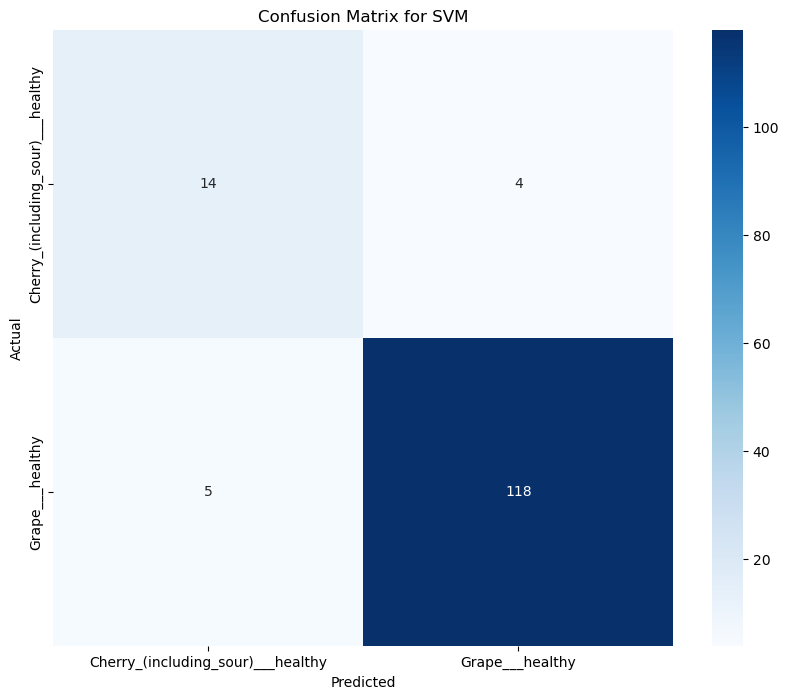

In [52]:
# For SVM Model
y_pred_svm = svm_classifier.predict(X_test_pca)  # Predictions from SVM
plot_confusion_matrix(y_test, y_pred_svm, class_names=label_encoder.classes_, model_name="SVM")